# Imports

In [ ]:
# !pip install shap

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, Dataset
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tqdm import tqdm
import copy
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Data

In [ ]:
csop_cols_to_ignore = [
    'conversation_num', 'batch_num', 'round_num', 'round_index',
    'task_index', 'complexity', 'type', 'social_perceptiveness',
    'skill', 'speaker_nickname', 'message', 'normalized_score',
    'zscore_score', 'zscore_round_duration', 'zscore_efficiency',
    'message_lower_with_punc', 'dale_chall_classification'
]

In [ ]:
csop_raw = pd.read_csv('/content/drive/MyDrive/CSS/csop_output_chat_level.csv')
csop_raw['timestamp'] = csop_raw.reset_index().groupby(by=['conversation_num'])['index'].rank(method='first').to_numpy()

conversation_nums = sorted(list(csop_raw['conversation_num'].unique()))
n_conversations = len(conversation_nums)
train_conversations, val_conversations = conversation_nums[:int(n_conversations*0.9)], conversation_nums[int(n_conversations*0.9):]

csop_raw['target'] = csop_raw['zscore_efficiency'].to_numpy()

train_csop_raw = csop_raw[csop_raw['conversation_num'].isin(train_conversations)].copy()
val_csop_raw = csop_raw[csop_raw['conversation_num'].isin(val_conversations)].copy()

train_csop = train_csop_raw.drop(csop_cols_to_ignore, axis=1).dropna().sample(frac=1)
val_csop = val_csop_raw.drop(csop_cols_to_ignore, axis=1).dropna().sample(frac=1)

X_train, y_train = train_csop.drop(['target'], axis=1), train_csop['target']
X_val, y_val = val_csop.drop(['target'], axis=1), val_csop['target']

feature_scaler = StandardScaler()
features_to_scale = [col for col in X_train.columns if col != 'timestamp']
X_train[features_to_scale] = feature_scaler.fit_transform(X_train[features_to_scale])
X_val[features_to_scale] = feature_scaler.transform(X_val[features_to_scale])
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2737, 97), (2737,), (613, 97), (613,))

# Helper Functions

In [ ]:
def calc_metrics(y_true, y_pred):
  r2 = r2_score(y_true=y_true, y_pred=y_pred).round(4)
  mse = mean_squared_error(y_true=y_true, y_pred=y_pred).round(4)
  rmse = np.sqrt(mse).round(4)
  mae = mean_absolute_error(y_true=y_true, y_pred=y_pred).round(4)
  return {'r2': r2, 'mse': mse, 'mae': mae, 'rmse': rmse}

# RNNs

## Preparing Datasets

In [ ]:
max_seq_length = csop_raw['conversation_num'].value_counts().sort_values(ascending=False).iloc[0]

In [ ]:
rnn_csop_train, rnn_csop_train_targets, rnn_csop_val, rnn_csop_val_targets = [], [], [], []
for conv_no in train_conversations:
  train_seq = train_csop_raw[train_csop_raw['conversation_num'] == conv_no].drop(csop_cols_to_ignore, axis=1)
  rnn_csop_train_targets.append(train_seq['target'].to_list()[0])
  train_seq_padding = max_seq_length - train_seq.shape[0]
  rnn_csop_train.append(np.r_[train_seq.drop(['target'], axis=1).to_numpy(), np.zeros((train_seq_padding, train_seq.shape[1]-1))])

for conv_no in val_conversations:
  val_seq = val_csop_raw[val_csop_raw['conversation_num'] == conv_no].drop(csop_cols_to_ignore, axis=1)
  rnn_csop_val_targets.append(val_seq['target'].to_list()[0])
  val_seq_padding = max_seq_length - val_seq.shape[0]
  rnn_csop_val.append(np.r_[val_seq.drop(['target'], axis=1).to_numpy(), np.zeros((val_seq_padding, train_seq.shape[1]-1))])

rnn_csop_train, rnn_csop_train_targets, rnn_csop_val, rnn_csop_val_targets = np.array(rnn_csop_train), np.array(rnn_csop_train_targets), np.array(rnn_csop_val), np.array(rnn_csop_val_targets)
rnn_csop_train, rnn_csop_val = np.nan_to_num(rnn_csop_train, nan=0), np.nan_to_num(rnn_csop_val, nan=0)
rnn_csop_train.shape, rnn_csop_train_targets.shape, rnn_csop_val.shape, rnn_csop_val_targets.shape

((882, 67, 97), (882,), (98, 67, 97), (98,))

In [ ]:
num_features = rnn_csop_train.shape[1]

## Vanilla RNNs

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(SimpleRNN(hidden_units, input_shape=input_shape,
                      activation=activation[0]))
  model.add(Dense(units=dense_units, activation=activation[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
rnn = create_RNN(
  hidden_units=max_seq_length,
  dense_units=1,
  input_shape=(rnn_csop_train.shape[1], rnn_csop_train.shape[2]),
  activation=['tanh', 'tanh']
)

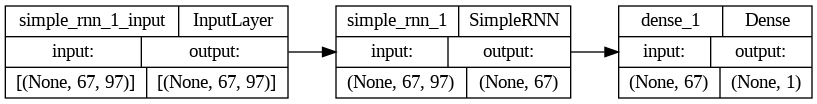

In [ ]:
tf.keras.utils.plot_model(rnn, show_shapes=True, rankdir="LR")

In [ ]:
rnn_callbacks = [
  EarlyStopping(monitor='val_loss', patience=10),
  ModelCheckpoint(
    filepath='best_rnn_model/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
  )
]
rnn_history = rnn.fit(
  x=rnn_csop_train, y=rnn_csop_train_targets, batch_size=64,
  validation_data = [rnn_csop_val, rnn_csop_val_targets], validation_batch_size=64,
  epochs=100, verbose=1, callbacks=rnn_callbacks
)

Epoch 1/100
14/14 [==============================] - 2s 57ms/step - loss: 0.9577 - val_loss: 0.9027
Epoch 2/100
14/14 [==============================] - 1s 42ms/step - loss: 0.8939 - val_loss: 0.8475
Epoch 3/100
14/14 [==============================] - 1s 42ms/step - loss: 0.8518 - val_loss: 0.7442
Epoch 4/100
14/14 [==============================] - 1s 40ms/step - loss: 0.8279 - val_loss: 0.7738
Epoch 5/100
14/14 [==============================] - 1s 41ms/step - loss: 0.8308 - val_loss: 0.7684
Epoch 6/100
14/14 [==============================] - 1s 39ms/step - loss: 0.8036 - val_loss: 0.7151
Epoch 7/100
14/14 [==============================] - 0s 35ms/step - loss: 0.8085 - val_loss: 0.7774
Epoch 8/100
14/14 [==============================] - 0s 35ms/step - loss: 0.8184 - val_loss: 0.7245
Epoch 9/100
14/14 [==============================] - 0s 35ms/step - loss: 0.8068 - val_loss: 0.7190
Epoch 10/100
14/14 [==============================] - 1s 40ms/step - loss: 0.8067 - val_loss: 0.7024

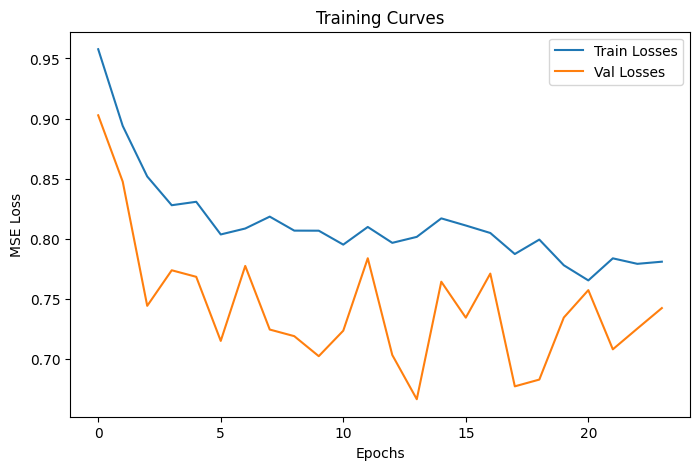

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(rnn_history.history['loss'], label='Train Losses')
ax.plot(rnn_history.history['val_loss'], label='Val Losses')
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Training Curves')
ax.legend()
plt.show()

In [ ]:
rnn_train_preds = rnn(rnn_csop_train).numpy().ravel()
rnn_val_preds = rnn(rnn_csop_val).numpy().ravel()

In [ ]:
# Train Metrics
calc_metrics(y_true=rnn_csop_train_targets, y_pred=rnn_train_preds)

{'r2': 0.2363, 'mse': 0.7568, 'mae': 0.6518, 'rmse': 0.8699}

In [ ]:
# Val Metrics
calc_metrics(y_true=rnn_csop_val_targets, y_pred=rnn_val_preds)

{'r2': 0.1848, 'mse': 0.7424, 'mae': 0.7121, 'rmse': 0.8616}

In [ ]:
# rnn.save('best_rnn_model.h5')

In [ ]:
# loaded_rnn = load_model('best_rnn_model.h5')
# rnn_train_preds = loaded_rnn(rnn_csop_train).numpy().ravel()
# rnn_val_preds = loaded_rnn(rnn_csop_val).numpy().ravel()
# print(calc_metrics(y_true=rnn_csop_train_targets, y_pred=rnn_train_preds))
# print(calc_metrics(y_true=rnn_csop_val_targets, y_pred=rnn_val_preds))

## GRUs

In [ ]:
def create_GRU(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(GRU(hidden_units, activation=activation[0]))
  model.add(Dense(units=dense_units, activation=activation[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
gru = create_GRU(
  hidden_units=max_seq_length,
  dense_units=1,
  input_shape=(rnn_csop_train.shape[1], rnn_csop_train.shape[2]),
  activation=['tanh', 'tanh']
)

In [ ]:
gru_callbacks = [
  EarlyStopping(monitor='val_loss', patience=10),
  ModelCheckpoint(
    filepath='best_gru_model/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
  )
]
gru_history = gru.fit(
  x=rnn_csop_train, y=rnn_csop_train_targets, batch_size=64,
  validation_data = [rnn_csop_val, rnn_csop_val_targets], validation_batch_size=64,
  epochs=100, verbose=1, callbacks=gru_callbacks
)

Epoch 1/100
14/14 [==============================] - 3s 36ms/step - loss: 0.9913 - val_loss: 1.0113
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.9903 - val_loss: 1.0102
Epoch 3/100
14/14 [==============================] - 0s 9ms/step - loss: 0.9917 - val_loss: 0.9914
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9900 - val_loss: 1.0111
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.9922 - val_loss: 1.0211
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9913 - val_loss: 0.9943
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.9901 - val_loss: 0.9994
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9898 - val_loss: 1.0078
Epoch 9/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9896 - val_loss: 1.0083
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.9900 - val_loss: 1.0087
Epoch 11

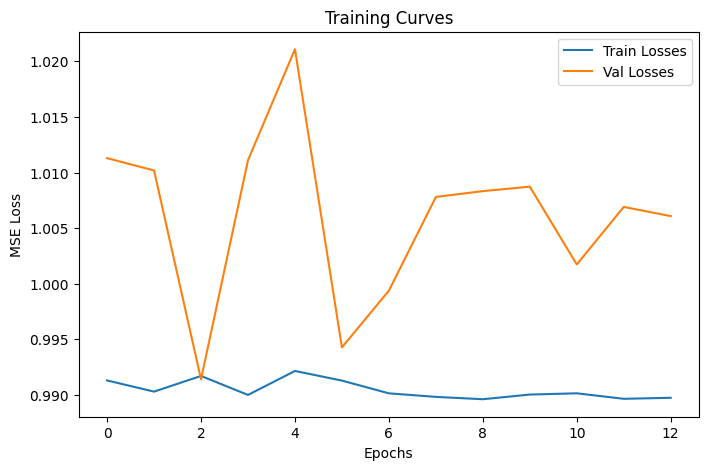

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(gru_history.history['loss'], label='Train Losses')
ax.plot(gru_history.history['val_loss'], label='Val Losses')
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Training Curves')
ax.legend()
plt.show()

In [ ]:
gru_train_preds = gru(rnn_csop_train).numpy().ravel()
gru_val_preds = gru(rnn_csop_val).numpy().ravel()

In [ ]:
# Train Metrics
calc_metrics(y_true=rnn_csop_train_targets, y_pred=gru_train_preds)

{'r2': 0.0017, 'mse': 0.9894, 'mae': 0.7777, 'rmse': 0.9947}

In [ ]:
# Val Metrics
calc_metrics(y_true=rnn_csop_val_targets, y_pred=gru_val_preds)

{'r2': -0.1048, 'mse': 1.0061, 'mae': 0.863, 'rmse': 1.003}

In [ ]:
# gru.save('best_gru_model.h5')

In [ ]:
# loaded_gru = load_model('best_gru_model.h5')
# gru_train_preds = loaded_gru(rnn_csop_train).numpy().ravel()
# gru_val_preds = loaded_gru(rnn_csop_val).numpy().ravel()
# print(calc_metrics(y_true=rnn_csop_train_targets, y_pred=gru_train_preds))
# print(calc_metrics(y_true=rnn_csop_val_targets, y_pred=gru_val_preds))

## LSTMs

In [ ]:
def create_LSTM(hidden_units, dense_units, input_shape, activation):
  model = Sequential()
  model.add(LSTM(hidden_units, input_shape=input_shape, activation=activation[0]))
  model.add(Dense(units=dense_units, activation=activation[1]))
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model

In [ ]:
lstm = create_LSTM(
  hidden_units=max_seq_length,
  dense_units=1,
  input_shape=(rnn_csop_train.shape[1], rnn_csop_train.shape[2]),
  activation=['tanh', 'tanh']
)

In [ ]:
lstm_callbacks = [
  EarlyStopping(monitor='val_loss', patience=10),
  ModelCheckpoint(
    filepath='best_lstm_model/',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
  )
]
lstm_history = lstm.fit(
  x=rnn_csop_train, y=rnn_csop_train_targets, batch_size=64,
  validation_data = [rnn_csop_val, rnn_csop_val_targets], validation_batch_size=64,
  epochs=100, verbose=1, callbacks=lstm_callbacks
)

Epoch 1/100
14/14 [==============================] - 2s 40ms/step - loss: 0.9945 - val_loss: 0.9940
Epoch 2/100
14/14 [==============================] - 0s 9ms/step - loss: 0.9365 - val_loss: 0.6175
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 0.8429 - val_loss: 0.6435
Epoch 4/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8140 - val_loss: 0.6316
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8102 - val_loss: 0.7005
Epoch 6/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8185 - val_loss: 0.6799
Epoch 7/100
14/14 [==============================] - 0s 8ms/step - loss: 0.8069 - val_loss: 0.6268
Epoch 8/100
14/14 [==============================] - 0s 8ms/step - loss: 0.7940 - val_loss: 0.6260
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 0.7927 - val_loss: 0.6949
Epoch 10/100
14/14 [==============================] - 0s 8ms/step - loss: 0.7869 - val_loss: 0.6514
Epoch 11

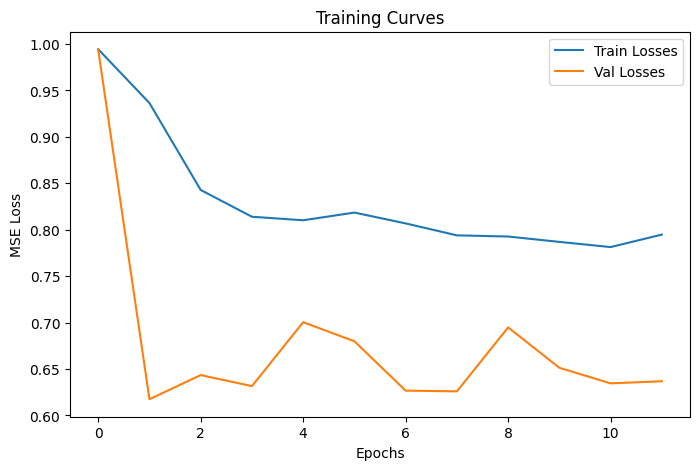

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(lstm_history.history['loss'], label='Train Losses')
ax.plot(lstm_history.history['val_loss'], label='Val Losses')
ax.set(xlabel='Epochs', ylabel='MSE Loss', title='Training Curves')
ax.legend()
plt.show()

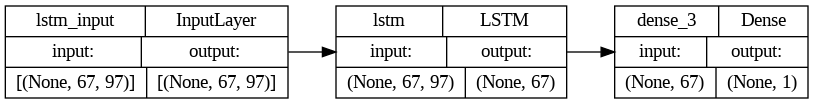

In [ ]:
tf.keras.utils.plot_model(lstm, show_shapes=True, rankdir="LR")

In [ ]:
lstm_train_preds = lstm(rnn_csop_train).numpy().ravel()
lstm_val_preds = lstm(rnn_csop_val).numpy().ravel()

In [ ]:
# Train Metrics
calc_metrics(y_true=rnn_csop_train_targets, y_pred=lstm_train_preds)

{'r2': 0.2155, 'mse': 0.7775, 'mae': 0.649, 'rmse': 0.8818}

In [ ]:
# Val Metrics
calc_metrics(y_true=rnn_csop_val_targets, y_pred=lstm_val_preds)

{'r2': 0.3006, 'mse': 0.6369, 'mae': 0.6435, 'rmse': 0.7981}

In [ ]:
# lstm.save('best_lstm_model.h5')

In [ ]:
# loaded_lstm = load_model('best_lstm_model.h5')
# lstm_train_preds = loaded_lstm(rnn_csop_train).numpy().ravel()
# lstm_val_preds = loaded_lstm(rnn_csop_val).numpy().ravel()
# print(calc_metrics(y_true=rnn_csop_train_targets, y_pred=lstm_train_preds))
# print(calc_metrics(y_true=rnn_csop_val_targets, y_pred=lstm_val_preds))